# Inference

In [3]:
using Distributions
using PGFPlots
using BayesNets

## Inference for Classification

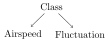

In [4]:
b = BayesNet([:Class, :Airspeed, :Fluctuation])
addEdge!(b, :Class, :Airspeed)
addEdge!(b, :Class, :Fluctuation)

In [5]:
# Set uniform prior over Class
setCPD!(b, :Class, CPDs.Discrete(["bird", "aircraft"], [0.5, 0.5]));

In [6]:
fluctuationParameters = a -> a[:Class] == "bird" ? [0.1, 0.9] : [0.9, 0.1]
setCPD!(b, :Fluctuation, CPDs.Discrete(["low", "hi"], fluctuationParameters));

In [7]:
# Function for plotting CPDs (don't worry about details here)
function plotCPD(cpd::CPDs.CPD, range::(Real,Real), assignments)
    convertAssignmentToString(a) = string(["$k = $v, " for (k,v) in a]...)[1:end-2]
    Axis(Plots.Plot[Plots.Linear(pdf(cpd, a), range, legendentry=convertAssignmentToString(a)) for a in assignments])
end;

In [8]:
# if Bird, then Airspeed ~ N(45,10)
# if Aircraft, then Airspeed ~ N(100,40)
airspeedParameters(a::Assignment) = a[:Class] == "bird" ? (45,10) : (100,40)
airspeedCPD = CPDs.Normal(airspeedParameters)
setCPD!(b, :Airspeed, airspeedCPD);

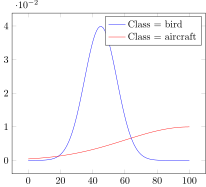

In [9]:
plotCPD(airspeedCPD, (0., 100.), [[:Class=>c] for c in ["bird", "aircraft"]])

In [10]:
pb = prob(b, [:Class=>"bird", :Airspeed=>65, :Fluctuation=>"low"])

0.00026995483256594033

In [11]:
pa = prob(b, [:Class=>"aircraft", :Airspeed=>65, :Fluctuation=>"low"])

0.003060618731758615

In [12]:
# Probability of aircraft given data
pa / (pa + pb)

0.9189464435022358

In [13]:
# View (unnormalized) distribution as a vector
d = [pb, pa]

2-element Array{Float64,1}:
 0.000269955
 0.00306062 

In [14]:
# Now normalize
d / sum(d)

2-element Array{Float64,1}:
 0.0810536
 0.918946 

## Inference in temporal models

Here is a simple crying baby temporal model. Whether the baby is crying is a noisy indication of whether the baby is hungry.

In [15]:
type State
    hungry
end
type Observation
    crying
end

States = [State(false), State(true)]
Observations = [Observation(false), Observation(true)]

# P(o|s)
function P(o::Observation, s::State)
    if s.hungry
        return o.crying ? 0.8 : 0.2
    else
        return o.crying ? 0.1 : 0.9
    end
end

# P(s' | s)
function P(s1::State, s0::State)
    if s0.hungry
        return s1.hungry ? 0.9 : 0.1
    else
        return s1.hungry ? 0.6 : 0.4
    end
end

# P(s)
P(s::State) = 1/length(States)

type Belief
    p::Vector{Float64}
end

Here are some sampling functions.

In [16]:
sampleState() = States[rand(Distributions.Categorical(Float64[P(s) for s in States]))]
sampleState(s::State) = States[rand(Distributions.Categorical(Float64[P(s1, s) for s1 in States]))]
sampleObservation(s::State) = Observations[rand(Distributions.Categorical(Float64[P(o, s) for o in Observations]))]
function generateSequence(steps)
    S = State[]
    O = Observation[]
    s = sampleState()
    push!(S, s)    
    o = sampleObservation(s)
    push!(O, o)
    for t = 2:steps
        s = sampleState(s)
        push!(S, s)    
        o = sampleObservation(s)
        push!(O, o)
    end
    (S, O)
end
(S, O) = generateSequence(20);

Update a belief as follows 

$b_1(s) \propto P(o \mid s) \sum_{s'} P(s \mid s') b_0(s')$

In [17]:
function update(b0::Belief, o::Observation)
    b1 = Belief(zeros(length(States)))
    for i = 1:length(States)
        s1 = States[i]
        b1.p[i] = P(o, s1) * sum([P(s1,States[j]) * b0.p[j] for j = 1:length(States)])
    end
    b1.p = b1.p / sum(b1.p)
    b1
end;

In [18]:
function printBeliefs(S::Vector{State}, O::Vector{Observation})
    print("s\to\tP(hungry)\n")
    n = length(S)
    b = Belief([0.5, 0.5])
    for t = 1:n
        b = update(b, O[t])
        @printf("%.0f\t%.0f\t%.3f\n", float(S[t].hungry), float(O[t].crying), b.p[2])
    end
end
printBeliefs(S, O)

s	o	P(hungry)
0	0	0.400
1	1	0.954
1	1	0.984
1	0	0.655
1	1	0.969
1	1	0.985
1	1	0.986
1	0	0.656
0	0	0.466
1	1	0.958
1	1	0.984
0	1	0.986
1	0	0.656
0	0	0.466
0	0	0.387
1	1	0.953
1	1	0.984
1	1	0.986
1	1	0.986
1	1	0.986


## Exact Inference

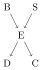

In [19]:
b = BayesNet([:B, :S, :E, :D, :C])
addEdges!(b, [(:B, :E), (:S, :E), (:E, :D), (:E, :C)])

In [20]:
setCPD!(b, :B, CPDs.Bernoulli(0.1))
setCPD!(b, :S, CPDs.Bernoulli(0.5))
setCPD!(b, :E, CPDs.Bernoulli([:B, :S], randBernoulliDict(2)))
setCPD!(b, :D, CPDs.Bernoulli([:E], randBernoulliDict(1)))
setCPD!(b, :C, CPDs.Bernoulli([:E], randBernoulliDict(1)));

Compute 

$P(b^1, d^1, c^1) = \sum_s \sum_e P(b^1)P(s)P(e \mid b^1, s)P(d^1 \mid e)P(c^1 \mid e)$

In [21]:
a = [:B=>1, :D=>1, :C=>1]

Dict{Symbol,Int64} with 3 entries:
  :D => 1
  :B => 1
  :C => 1

In [22]:
T = table(b,:B,a)*table(b,:S)*table(b,:E,a)*table(b,:D,a)*table(b,:C,a)

,B,S,E,D,C,p
1,true,false,false,true,true,0.01309985
2,true,true,false,true,true,0.007697850000000002
3,true,false,true,true,true,0.00048510000000000003
4,true,true,true,true,true,0.0069531


In [23]:
sumout(T, [:S, :E])

,B,D,C,p
1,true,true,true,0.0282359


## Approximate Inference

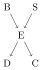

In [24]:
b = BayesNet([:B, :S, :E, :D, :C])
addEdges!(b, [(:B, :E), (:S, :E), (:E, :D), (:E, :C)])
setCPD!(b, :B, CPDs.Bernoulli(0.1))
setCPD!(b, :S, CPDs.Bernoulli(0.5))
setCPD!(b, :E, CPDs.Bernoulli([:B, :S], randBernoulliDict(2)))
setCPD!(b, :D, CPDs.Bernoulli([:E], randBernoulliDict(1)))
setCPD!(b, :C, CPDs.Bernoulli([:E], randBernoulliDict(1)))
b

In [25]:
rand(b)

Dict{Any,Any} with 5 entries:
  :D => true
  :B => false
  :C => false
  :E => true
  :S => false

In [26]:
randTable(b, numSamples=8)

,B,C,D,E,S
1,false,false,true,false,true
2,false,false,true,true,false
3,false,false,false,true,false
4,false,true,true,false,false
5,false,false,true,false,true
6,false,false,false,false,true
7,false,true,false,true,false
8,false,false,false,false,true


### Example chemical detection network

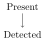

In [27]:
b = BayesNet([:Present, :Detected])
addEdge!(b, :Present, :Detected)
setCPD!(b, :Present, CPDs.Bernoulli(0.001))
setCPD!(b, :Detected, CPDs.Bernoulli(a->a[:Present] == true ? 0.999 : 0.001))
b

In [28]:
randTable(b, numSamples=10)

,Detected,Present
1,false,false
2,false,false
3,false,false
4,false,false
5,false,false
6,false,false
7,false,false
8,false,false
9,false,false
10,false,false


Not very interesting since all the samples are likely to be (false, false)

In [29]:
randTable(b, numSamples=1000, consistentWith=[:Detected=>true])

,Detected,Present
1,true,true


Even with 1000 samples, we are not likely to get many samples that are consistent with Detected = true. This can result in a pretty poor estimate.

In [30]:
estimate(randTable(b, numSamples=10000, consistentWith=[:Detected=>true]))

,Detected,Present,p
1,true,false,0.5294117647058824
2,true,true,0.47058823529411764


### Likelihood weighted sampling

In [31]:
randTableWeighted(b, numSamples=10, consistentWith=[:Detected=>true])

,Detected,Present,p
1,true,false,0.09999999999999998
2,true,false,0.09999999999999998
3,true,false,0.09999999999999998
4,true,false,0.09999999999999998
5,true,false,0.09999999999999998
6,true,false,0.09999999999999998
7,true,false,0.09999999999999998
8,true,false,0.09999999999999998
9,true,false,0.09999999999999998
10,true,false,0.09999999999999998


In [32]:
estimate(randTableWeighted(b, numSamples=10000, consistentWith=[:Detected=>true]))

,Detected,Present,p
1,true,false,0.5263407438626063
2,true,true,0.47365925613739374
